# Detecting Directional Cycles: A Toy Example of PPH vs PH

This notebook presents a **toy example** illustrating the advantage of **Path Persistent Homology (PPH)** over classical **Persistent Homology (PH)**. The **toy network** contains two circular interaction patterns—one representing a **conventional cycle** and another a **directional (non-conventional) interaction loop**. PPH **successfully detects both cycles**, as it accounts for the network’s directed and functional interaction structure, wheras PH **does not**, since it relies only on growing metric balls around data points during computation. This demonstrates how PPH integrates biological network information with simulated gene expression dynamics to reveal interaction patterns that PH alone would miss.


In [1]:
import numpy as np                       # Numerical computations, array and matrix handling
import pandas as pd                      # DataFrame operations for expression and KEGG data
import matplotlib.pyplot as plt          # Plotting and visualization
import networkx as nx                    # Graph and network analysis
from scipy.linalg import eigh            # Eigenvalue and eigenvector computation
import cmasher as cmr                    # Colormaps for scientific visualization
import seaborn as sns                    # Statistical data visualization
from core import GenPathHomology         # Custom module for generalized path homology computation
from utils import plot_betti_numbers, betti_to_pairs_single  # Helper functions for plotting and Betti pair extraction
import gudhi as gd                       # Topological data analysis (persistent homology) library

In [2]:
# Define the graph edges
toy_edges = [
    ("g1", "g2"), ("g2", "g3"), ("g3", "g4"), ("g4", "g1"), 
    ("g6", "g7"), ("g6", "g8"), ("g9", "g7"), ("g9", "g8"),
    ("g5", "g2")
]

# List of all genes
toy_genes = [f"g{i}" for i in range(1, 11)]

# Initialize an adjacency matrix with zeros
toy_adj_matrix = pd.DataFrame(0, index=toy_genes, columns=toy_genes)

# Fill the adjacency matrix based on the edges
for src, dest in toy_edges:
    toy_adj_matrix.loc[src, dest] = 1  # Mark the edge

# Display the adjacency DataFrame
toy_adj_matrix

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10
g1,0,1,0,0,0,0,0,0,0,0
g2,0,0,1,0,0,0,0,0,0,0
g3,0,0,0,1,0,0,0,0,0,0
g4,1,0,0,0,0,0,0,0,0,0
g5,0,1,0,0,0,0,0,0,0,0
g6,0,0,0,0,0,0,1,1,0,0
g7,0,0,0,0,0,0,0,0,0,0
g8,0,0,0,0,0,0,0,0,0,0
g9,0,0,0,0,0,0,1,1,0,0
g10,0,0,0,0,0,0,0,0,0,0


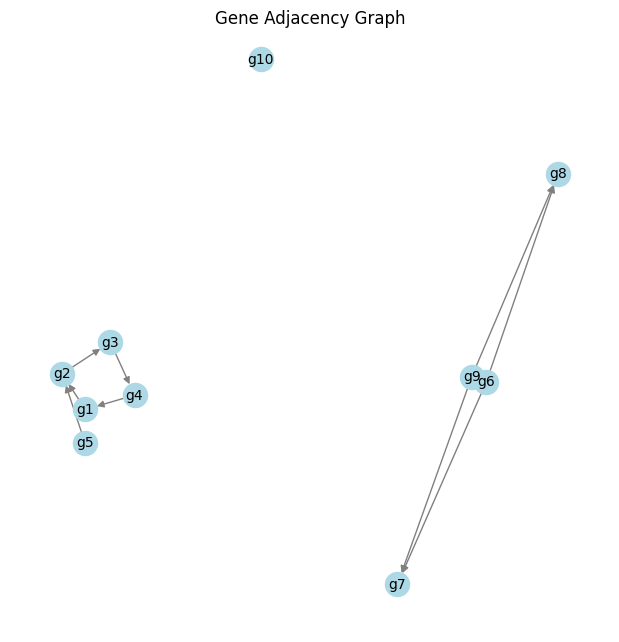

In [3]:
# Create directed graph
toy_G = nx.DiGraph()
toy_G.add_edges_from(toy_edges)

# Add isolated nodes explicitly
toy_G.add_nodes_from(toy_genes)

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(toy_G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=10)
plt.title("Gene Adjacency Graph")
plt.show()

In [4]:
def nearest_positive_semidefinite(matrix):
    """Adjust a matrix to be positive semidefinite."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(matrix)
    # Set negative eigenvalues to zero
    eigenvalues = np.maximum(eigenvalues, 0)
    # Reconstruct the matrix
    return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

In [5]:
np.random.seed(42) # Set random seed for reproducibility

toy_samples = ["C1", "C2", "C3", "D1", "D2", "D3"]

# Step 1: Generate base raw counts (randomized)
toy_base_counts = np.random.poisson(lam=10, size=(10, 6))  # Simulate raw counts

# Step 2: Normalize and log-transform the counts
toy_normalized_data = np.log2(toy_base_counts + 1)  # Add 1 to avoid log(0)

# Step 3: Adjust data for correlations
# Create a covariance matrix to simulate correlations among genes
toy_correlation_matrix = np.array([
    [1.0, 0.8, 0.2, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # G1 correlated with G2
    [0.7, 1.0, 0.3, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # G2 correlated with G1, G3
    [0.2, 0.3, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # G3 weak correlations
    [0.5, 0.6, 0.5, 1.0, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0],  # G4 mid correlations
    [0.0, 0.0, 0.0, 0.4, 1.0, 0.7, 0.5, 0.0, 0.0, 0.0],  # G5 mid-strong correlations
    [0.0, 0.0, 0.0, 0.2, 0.5, 1.0, 0.6, 0.0, 0.0, 0.0],  # G6 correlated with G5
    [0.0, 0.0, 0.0, 0.0, 0.5, 0.6, 1.0, 0.8, 0.3, 0.0],  # G7 and G8 correlations
    [0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.8, 1.0, 0.4, 0.0],  # G8 correlated with G7
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.4, 1.0, 0.5],  # G9 mid correlations
    [0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]   # G10 weak correlations
])

toy_correlation_matrix = nearest_positive_semidefinite(toy_correlation_matrix)

# Step 4: Generate correlated gene expressions
toy_control_data = np.random.multivariate_normal(
    mean=np.mean(toy_normalized_data[:, :3], axis=1),
    cov=toy_correlation_matrix,
    size=3
).T

toy_disease_data = np.random.multivariate_normal(
    mean=np.mean(toy_normalized_data[:, 3:], axis=1) + np.random.uniform(-0.5, 0.5, 10),  # Alter genes slightly
    cov=toy_correlation_matrix,
    size=3
).T

# Combine control and disease
toy_final_data = np.hstack([toy_control_data, toy_disease_data])

# Convert to DataFrame
toy_expression_df = pd.DataFrame(toy_final_data, index=toy_genes, columns=toy_samples)

# View the expression data
toy_expression_df

,C1,C2,C3,D1,D2,D3
g1,3.224085,4.238909,3.573100,2.281019,2.904727,3.252311
g2,2.801195,3.629210,3.212241,2.832321,3.747732,2.882458
g3,4.568956,3.268862,3.689043,2.781017,3.834468,3.507576
g4,3.531844,2.599495,2.618524,3.107632,3.402103,4.700751
g5,4.695837,4.608166,4.677947,3.766694,1.826884,4.893230
g6,4.001411,4.770909,4.668929,2.451091,4.178800,2.988391
g7,4.279513,4.427967,5.506402,2.991138,3.061895,2.712762
g8,4.223187,3.225830,4.907987,2.766738,2.861530,2.355171
g9,3.765850,3.609896,4.185733,1.280467,1.476483,2.873749
g10,4.121385,4.167441,2.948542,1.734737,3.004740,3.177959


In [6]:
# Toy example correlation-based distance
toy_distance_corr_abs = 1- np.abs(toy_expression_df.T.corr())

# Set gene labels assuming toy_genes contains gene names (e.g., ['g1', 'g2', ..., 'g10'])
gene_labels = toy_genes

# Create a mask to overlay highlights
highlight_mask = np.zeros_like(toy_expression_df.T.corr(), dtype=bool)
for gene1, gene2 in toy_edges:
    i, j = toy_genes.index(gene1), toy_genes.index(gene2)
    highlight_mask[i, j] = True
    
# Define a diverging color palette for correlation and distance measures
cmap_corr = sns.color_palette("PiYG", as_cmap=True)  # Diverging for correlation
cmap_corr_abs = cmr.get_sub_cmap('PiYG_r', 0, 0.5)
cmap_corr_dir = sns.color_palette("PiYG_r", as_cmap=True)  # Diverging for correlation
cmap_distance = sns.color_palette("YlOrRd", as_cmap=True)  # Sequential for highlights

### Individual Heatmaps
#### Heatmap for correlation full

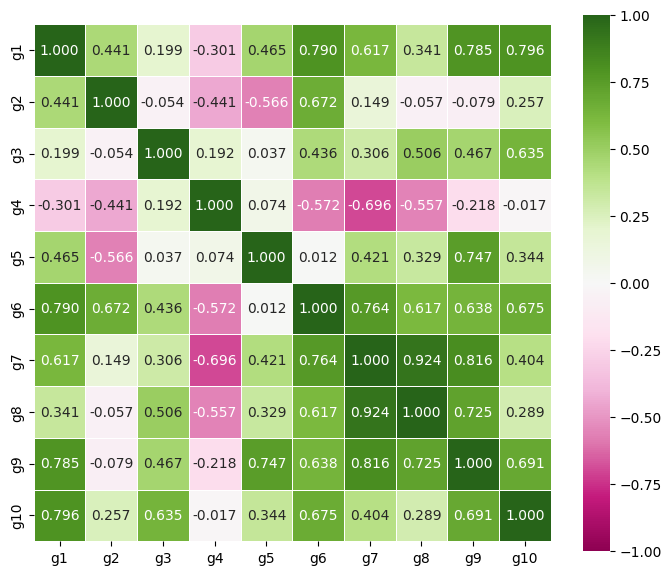

In [7]:
plt.figure(figsize=(7, 7))
sns.heatmap(toy_expression_df.T.corr(), annot=True, cmap=cmap_corr, cbar=True, cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white', square=True, 
            xticklabels=gene_labels, yticklabels=gene_labels, vmin=-1, vmax=1, fmt=".3f")

plt.tight_layout()
plt.show()

#### Heatmap for correlation overlaid

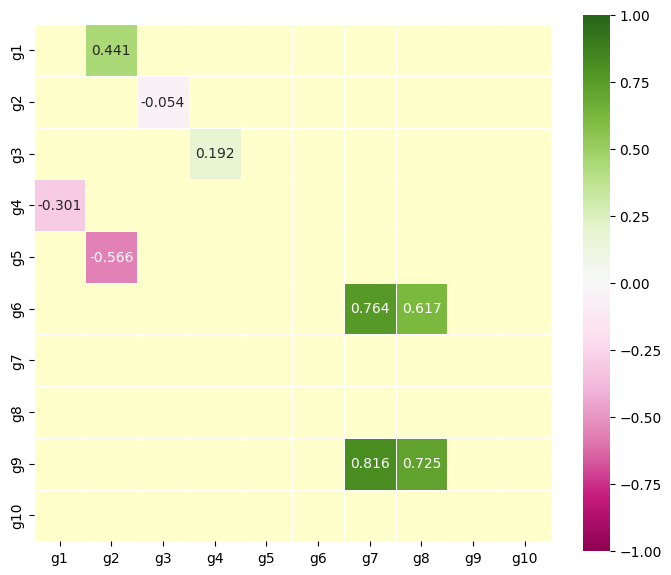

In [8]:
plt.figure(figsize=(7, 7))
sns.heatmap(toy_expression_df.T.corr(), annot=True, cmap=cmap_corr, mask=~highlight_mask, 
            cbar=True, cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white', square=True, 
            xticklabels=gene_labels, yticklabels=gene_labels, vmin=-1, vmax=1, fmt=".3f")
sns.heatmap(np.zeros_like(toy_expression_df.T.corr()), annot=False, cmap=cmap_distance, 
            mask=highlight_mask, cbar=False, linewidths=0.5, linecolor='white', square=True, 
            xticklabels=gene_labels, yticklabels=gene_labels)
plt.tight_layout()
plt.show()

#### Heatmap for distance correlations (1-absolute(correlations))

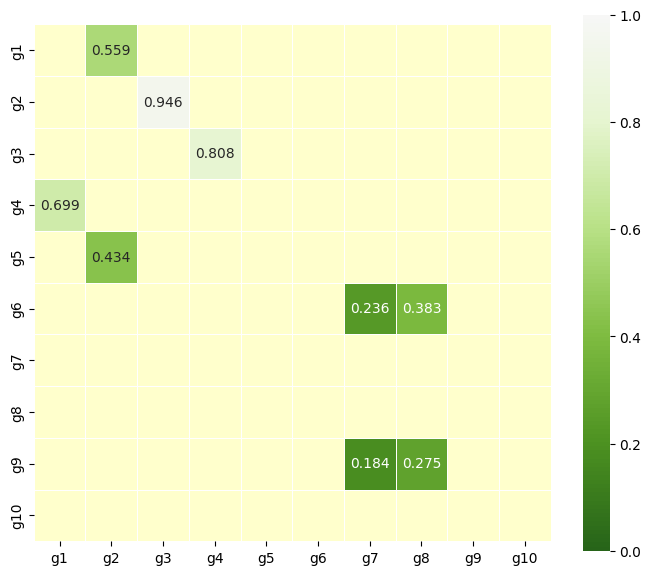

In [9]:
plt.figure(figsize=(7, 7))
sns.heatmap(toy_distance_corr_abs, annot=True, cmap=cmap_corr_abs, mask=~highlight_mask, 
            cbar=True, cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white', square=True, 
            xticklabels=gene_labels, yticklabels=gene_labels, vmin=0, vmax=1, fmt=".3f")  # Limit legend range
sns.heatmap(np.zeros_like(toy_distance_corr_abs), annot=False, cmap=cmap_distance, 
            mask=highlight_mask, cbar=False, linewidths=0.5, linecolor='white', square=True, 
            xticklabels=gene_labels, yticklabels=gene_labels)
plt.tight_layout()
plt.show()

### PPH Computation

In [10]:
# Initialize GenPathHomology
pph = GenPathHomology()

# Filtration
toy_filtration_abs = np.arange(0, 1, 0.01)

In [11]:
# Identify all existing edges in the toy adjacency matrix and stores them as coordinate pairs
nonzero_indices = np.nonzero(toy_adj_matrix)
rows, cols = nonzero_indices

toy_edges_adj = list(zip(rows, cols))
toy_edges_adj = np.array(toy_edges_adj)

In [12]:
# Compute Betti numbers for dimension 0
betti_0, edges_0 = pph.persistent_path_homology_from_digraph(np.array(toy_expression_df),
                                                             toy_edges_adj,
                                                             target_dimension=0,
                                                             filtration=toy_filtration_abs,
                                                             distance_type='1-abs-correlation'
)

In [13]:
# Compute Betti numbers for dimension 1
betti_1, edges_1 = pph.persistent_path_homology_from_digraph(np.array(toy_expression_df),
                                                             toy_edges_adj,
                                                             target_dimension=1,
                                                             filtration=toy_filtration_abs,
                                                             distance_type='1-abs-correlation'
)

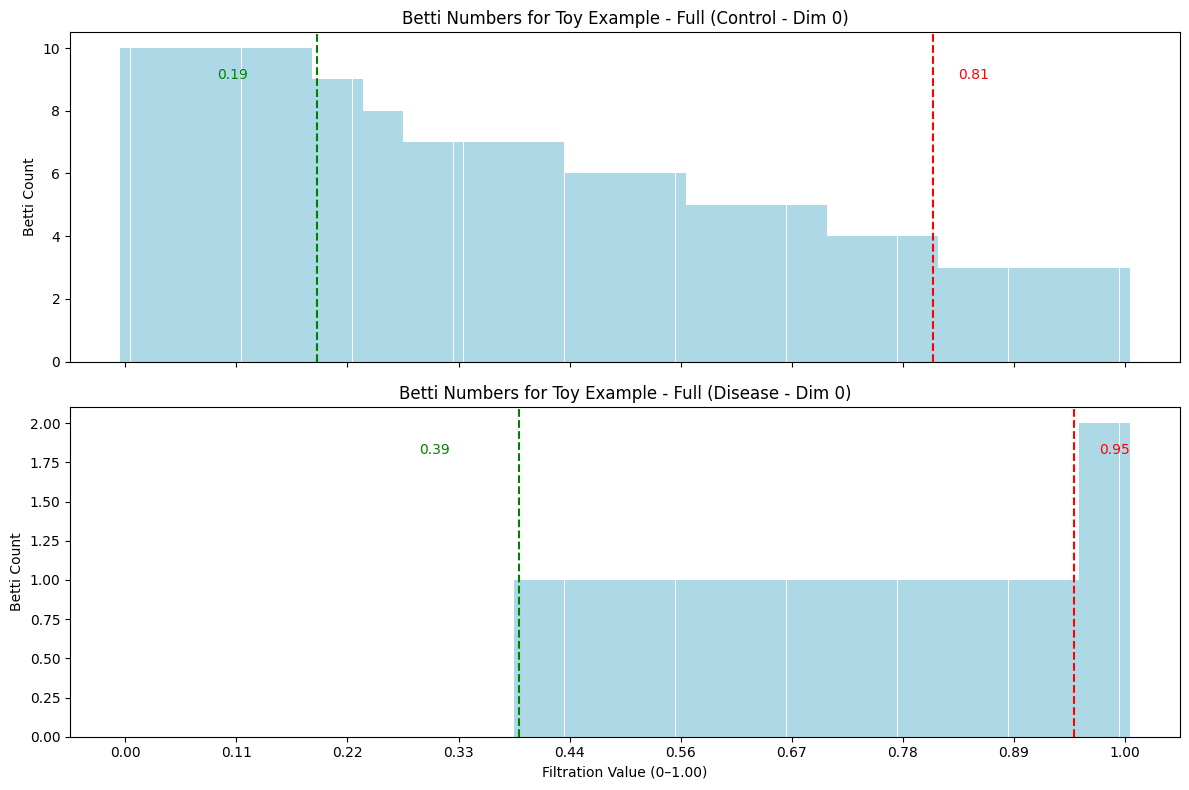

In [14]:
# Plot the series of Betti numbers in both dimensions
plot_betti_numbers('Toy Example - Full', np.array(betti_0), np.array(betti_1), save_plot=False)

### PH Computation

In [15]:
# Build Rips filtration and compute persistence for control
rips_complex_abs = gd.RipsComplex(distance_matrix=np.array(toy_distance_corr_abs), max_edge_length=2.0)
simplex_tree_abs = rips_complex_abs.create_simplex_tree(max_dimension=2)
diag_abs = simplex_tree_abs.persistence()  

<Figure size 600x500 with 0 Axes>

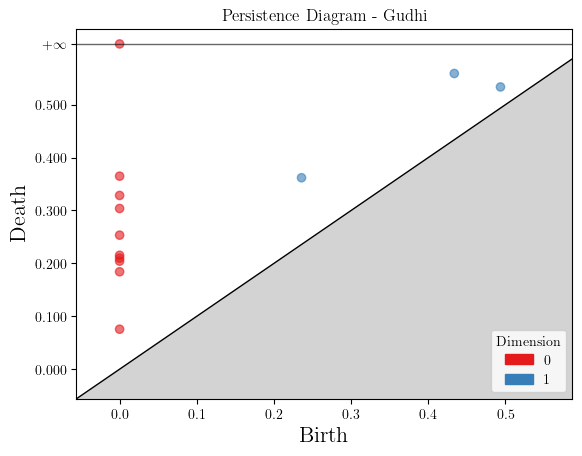

In [16]:
# Create a figure for the 'PH' diagrams
plt.figure(figsize=(6, 5))
gd.plot_persistence_diagram(diag_abs)
plt.title("Persistence Diagram - Gudhi")
#plt.savefig("toy_pers_diag_PH.png", dpi=300)
plt.show()    

<Figure size 600x400 with 0 Axes>

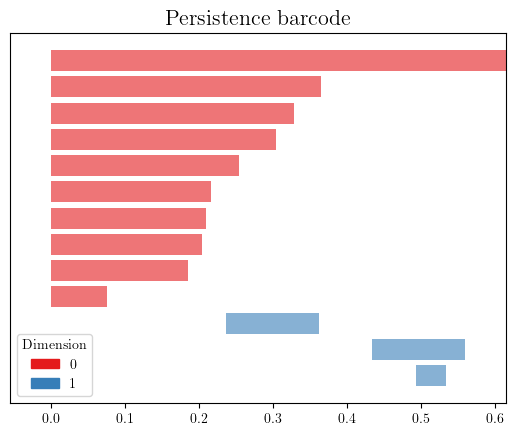

In [17]:
# Create a figure for the 'PH' barcode
plt.figure(figsize=(6, 4))
gd.plot_persistence_barcode(diag_abs)
#plt.savefig("toy_barcode_PH.png", dpi=300, bbox_inches='tight')
plt.show()   

### Barcode Visualization - PH vs PPH

In [18]:
# Separate persistent diagrams from PH by dimension
diag_abs_0 = [pair for dim, pair in diag_abs if dim == 0]
diag_abs_1 = [pair for dim, pair in diag_abs if dim == 1]

In [19]:
diag_abs_0

[(0.0, inf),
 (0.0, 0.3648772541696762),
 (0.0, 0.3283919602815589),
 (0.0, 0.30373553108927764),
 (0.0, 0.2533592391368408),
 (0.0, 0.215295972818213),
 (0.0, 0.2098034367332281),
 (0.0, 0.2042010321529243),
 (0.0, 0.1841563843233065),
 (0.0, 0.07555786958599253)]

In [20]:
# Create a dictionary to store persistent diagrams from PH and PPH
toy_pers_diag_dict = {}
for label in ['ph', 'pph']:
    toy_pers_diag = []
    for dim in [0, 1]:
        if dim == 0 and label=='pph':
            for it in betti_to_pairs_single(betti_0, toy_filtration_abs):
                item = (dim, it)
                toy_pers_diag.append(item)
        elif dim == 1 and label=='pph':
            for it in betti_to_pairs_single(betti_1, toy_filtration_abs):
                item = (dim, it)
                toy_pers_diag.append(item)
        elif dim==0 and label=='ph':
            for it in diag_abs_0:
                item = (dim, it)
                toy_pers_diag.append(item)
        elif dim==1 and label=='ph':
            for it in diag_abs_1:
                item = (dim, it)
                toy_pers_diag.append(item)
                
    toy_pers_diag_dict[label] = toy_pers_diag
#toy_pers_diag_dict

In [21]:
# Function to sort persistence intervals in descending order by death value
def sort_by_interval(entries):
    return sorted(entries, key=lambda x: x[1][1], reverse=True)

# Apply the sorting to both approach
sorted_toy_pers_diag_dict = {
    'ph': sort_by_interval(toy_pers_diag_dict['ph']),
    'pph': sort_by_interval(toy_pers_diag_dict['pph'])
}

# Print the sorted dictionary
#sorted_toy_pers_diag_dict

#### Barcode plot from PH

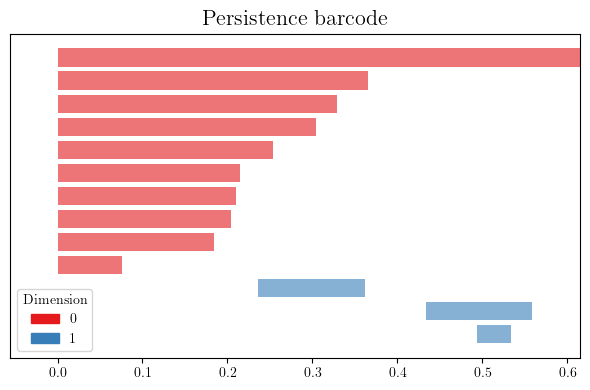

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
gd.plot_persistence_barcode(sorted_toy_pers_diag_dict['ph'], axes=ax)
plt.tight_layout()
# plt.savefig("barcode_PH.png", dpi=300)
plt.show()

#### Barcode plot from PPH

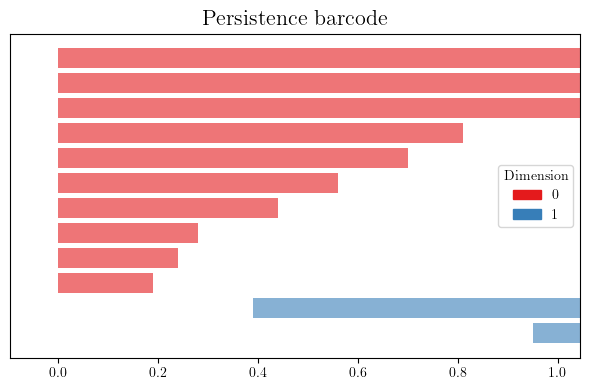

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
gd.plot_persistence_barcode(sorted_toy_pers_diag_dict['pph'], axes=ax)
plt.tight_layout()
# plt.savefig("barcode_PPH.png", dpi=300)
plt.show()